### Distance Metrics

#### 1. Motivation

정보 이론, 특히 Shannon's entropy 개념은 금융에 유용한 응용 분야를 갖고 있다. 엔트로피의 핵심 아이디어는 랜덤 변수와 관련된 불확실성의 양을 계량화하는 것이다. 많은 머신러닝 알고리즘의 1차 목표는 문제 해결과 관련된 불확실성의 양을 줄이는 것이기 때문에 정보 이론은 머신러닝에 필수적이다

#### 2. A Correlation-Based Metric

상관계수는 선형적 상호의존성의 유용한 척도이다. 일단 상관계수 행렬의 잡음과 주음이 제거되면 시스템에 대한 중요한 구조 정보를 보일 수 있다. 예를 들어, 상호연관성이 매우 높은 유가증권의 군집을 식별하고자 상관계수를 사용할 수 있다

그러나, 상관계수를 사용하기 전에 기술적 문제를 해결해야 한다. 상관계수는 비음성과 삼각 부등식 조건을 충족시키지 못하기 때문에 척도가 되지 못한다. 거리 척도는 집합에 대한 직관적인 위상관계를 유도하기 때문에 중요하다. 이러한 직관적 위상관계 없이 상호의존성의 비거리적 측정을 비교하는 것은 다소 일관성 없는 결과를 초래할 수 있다

In [1]:
import pandas_datareader as web
start_date = '2019-09-01'
end_date = '2023-08-31'

kodex_etf = '069500' # KODEX 200
kospi200_etf = '069660'  # kiwoom KOSEF KOSPI 200
kosdaq150_etf = '316670'  # kiwoom KOSDAQ 150
samsung_code = '005930'  # Samsung
lg_code = '066570'  # LG
posco_code = '005490'  # POSCO

kodex = web.DataReader(kodex_etf, 'naver', start = start_date, end = end_date).astype(float).Close
kospi = web.DataReader(kospi200_etf, 'naver', start = start_date, end = end_date).astype(float).Close
kosdaq = web.DataReader(kosdaq150_etf, 'naver', start = start_date, end = end_date).astype(float).Close
samsung = web.DataReader(samsung_code, 'naver', start = start_date, end = end_date).astype(float).Close
lg = web.DataReader(lg_code, 'naver', start = start_date, end = end_date).astype(float).Close
posco = web.DataReader(posco_code, 'naver', start = start_date, end = end_date).astype(float).Close

In [2]:
import numpy as np
import pandas as pd

kodex_ret = np.log(kodex/kodex.shift(1)).dropna()
kospi_ret = np.log(kospi/kospi.shift(1)).dropna()
kosdaq_ret = np.log(kosdaq/kosdaq.shift(1)).dropna()
samsung_ret = np.log(samsung/samsung.shift(1)).dropna()
lg_ret = np.log(lg/lg.shift(1)).dropna()
posco_ret = np.log(posco/posco.shift(1)).dropna()
matrix = pd.concat([kodex_ret, kospi_ret, kosdaq_ret, samsung_ret, lg_ret, posco_ret], axis = 1)
matrix.columns = ['KODEX','KOSPI','KOSDAQ','Samsung','LG','Posco']

In [3]:
matrix.corr()

,KODEX,KOSPI,KOSDAQ,Samsung,LG,Posco
KODEX,1.000000,0.997660,0.737888,0.853203,0.522377,0.565980
KOSPI,0.997660,1.000000,0.734899,0.854983,0.521810,0.563844
KOSDAQ,0.737888,0.734899,1.000000,0.523702,0.375575,0.373946
Samsung,0.853203,0.854983,0.523702,1.000000,0.385661,0.422512
LG,0.522377,0.521810,0.375575,0.385661,1.000000,0.297815
Posco,0.565980,0.563844,0.373946,0.422512,0.297815,1.000000


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from RandomMatrixWithSignal import cov2corr, getRndCov
from MarcenkoPastur import getPCA
from FittingMarcenkoPastur import findMaxEval
from ConstantResidual import denoisedCorr, denoisedCorr2

alpha, nCols, nFact, q = 0.995, 6, 100, 10

cov = alpha * matrix.cov() + (1-alpha) * getRndCov(nCols, nFact)
corr0 = cov2corr(cov)
eVal0, eVec0 = getPCA(corr0)

eMax0, var0 = findMaxEval(np.diag(eVal0), q, bWidth = 0.01)
nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)

corr1 = denoisedCorr(eVal0, eVec0, nFacts0)
eVal1, eVec1 = getPCA(corr1)
denoised_eigenvalue = np.diag(eVal1)
eigenvalue_prior = np.diag(eVal0)

Text(0.5, 1.0, 'Denoising with Constant residual eigenvalue method')

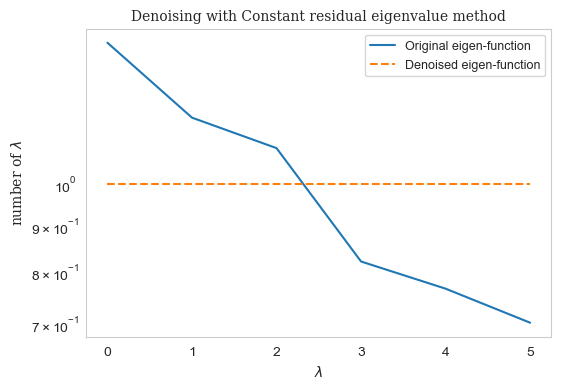

In [20]:
plt.figure(figsize = (6,4))
plt.grid(False)
plt.plot(eigenvalue_prior, label = 'Original eigen-function')
plt.plot(denoised_eigenvalue, label = 'Denoised eigen-function', ls = '--')
plt.yscale('log')
plt.xlabel(r'$\lambda$', fontfamily='Serif')
plt.ylabel(r'number of $\lambda$', fontfamily='Serif')
plt.legend(loc='upper right', fontsize=9)
plt.title('Denoising with Constant residual eigenvalue method', fontsize=10, fontfamily='Serif')

In [23]:
eVec1

array([[ 0.64263467, -0.35422997, -0.22916047,  0.52777864, -0.61018994,
         0.05335529],
       [-0.04721656,  0.28092835, -0.79702726,  0.09435643,  0.35317647,
         0.38737518],
       [-0.65705758,  0.38576438, -0.20978944, -0.04600428, -0.65656866,
         0.15689025],
       [-0.24361258,  0.00210571,  0.23286825,  0.81450602,  0.25273222,
         0.15800076],
       [-0.08061912,  0.39666561,  0.46229874, -0.067245  , -0.08708994,
         0.65731381],
       [-0.29533047,  0.69959859, -0.01654335,  0.20612673, -0.0198487 ,
        -0.60452746]])

In [21]:
def corrBasedMetric(corr : pd.DataFrame) -> pd.DataFrame :
    T = len(corr.iloc[:,0])
    result = np.sqrt(2 * T) * corr
    return result

In [26]:
corrBasedMetric(pd.DataFrame(eVec1, columns = matrix.columns))

,KODEX,KOSPI,KOSDAQ,Samsung,LG,Posco
0,2.226152,-1.227089,-0.793835,1.828279,-2.113760,0.184828
1,-0.163563,0.973164,-2.760983,0.326860,1.223439,1.341907
2,-2.276114,1.336327,-0.726732,-0.159364,-2.274421,0.543484
3,-0.843899,0.007294,0.806679,2.821532,0.875490,0.547331
4,-0.279273,1.374090,1.601450,-0.232944,-0.301688,2.277002
5,-1.023055,2.423481,-0.057308,0.714044,-0.068758,-2.094145


#### 3. Marginal and Joint Entropy

In [10]:
import numpy as np,scipy.stats as ss
from sklearn.metrics import mutual_info_score 

def numBins(nObs,corr=None):
    if corr is None: # univariate case
        z=(8+324*nObs+12*(36*nObs+729*nObs**2)**.5)**(1/3.)
        b=round(z/6.+2./(3*z)+1./3) 
    else: # bivariate case
        b=round(2**-.5*(1+(1+24*nObs/(1.-corr**2))**.5)**.5) 
    return int(b)
def varInfo(x,y,norm=False):
    bXY=numBins(x.shape[0],corr=np.corrcoef(x,y)[0,1]) 
    cXY=np.histogram2d(x,y,bXY)[0] 
    iXY=mutual_info_score(None,None,contingency=cXY) 
    hX=ss.entropy(np.histogram(x,bXY)[0]) # marginal 
    hY=ss.entropy(np.histogram(y,bXY)[0]) # marginal 
    vXY=hX+hY-2*iXY # variation of information
    if norm:
        hXY=hX+hY-iXY # joint
        vXY/=hXY # normalized variation of information
    return vXY

In [14]:
bins = numBins(len(kospi_ret))

In [15]:
cXY=np.histogram2d(kospi_ret, kosdaq_ret)[0] 
hX=ss.entropy(np.histogram(kospi_ret,bins)[0]) # marginal 
hY=ss.entropy(np.histogram(kosdaq_ret,bins)[0]) # marginal 
iXY=mutual_info_score(None,None,contingency=cXY) 
iXYn=iXY/min(hX,hY) # normalized mutual information 
hXY=hX+hY-iXY # joint
hX_Y=hXY-hY # conditional
hY_X=hXY-hX # conditional

In [17]:
print(iXYn, hXY,hX_Y,hY_X)

0.1945808818635761 2.9397457047255373 1.2047272772418083 1.4439688475417864
